In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import string

In [46]:
df = pd.read_csv('https://github.com/Kytabyte/Spooky-Author-Identification/blob/master/train/train.csv?raw=true')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [47]:
df['id_new']=df['id'].apply(lambda x: x[2:])
df = df.drop(['id'], axis=1)
df.head()

,text,author,id_new
0,"This process, however, afforded me no means of...",EAP,26305
1,It never once occurred to me that the fumbling...,HPL,17569
2,"In his left hand was a gold snuff box, from wh...",EAP,11008
3,How lovely is spring As we looked from Windsor...,MWS,27763
4,"Finding nothing else, not even gold, the Super...",HPL,12958


Text(0.5, 1.0, 'Total Number of text entries in DataFrame of each author')

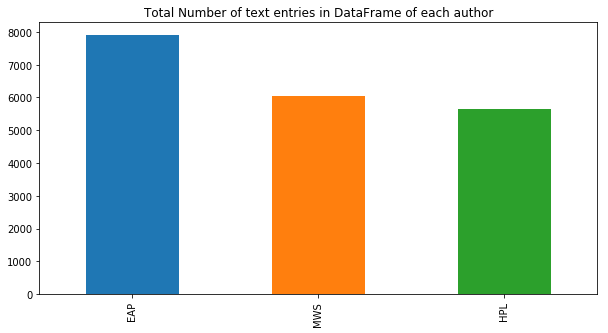

In [48]:
df['author'].value_counts().plot(kind='bar')
plt.title('Total Number of text entries in DataFrame of each author')

In [49]:
#Text Preprocessing
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()
stopword = set(stopwords.words('english'))
def tok(text):
    words = word_tokenize(text) #split words
    words = [w.lower() for w in words if w.isalpha()] #get rid of punctuation
    words =[w for w in words if not w in stopword]
    stemmed = [porter.stem(w) for w in words]
    lemmatized = ' '.join([lemmatizer.lemmatize(w) for w in stemmed])
    return lemmatized
df['text']=df['text'].apply(lambda x: tok(x))
df.head()

,text,author,id_new
0,process howev afford mean ascertain dimens dun...,EAP,26305
1,never occur fumbl might mere mistak,HPL,17569
2,left hand gold snuff box caper hill cut manner...,EAP,11008
3,love spring look windsor terrac sixteen fertil...,MWS,27763
4,find noth el even gold superintend abandon att...,HPL,12958


Text(0.5, 1.0, 'Mean Character Length of Authors')

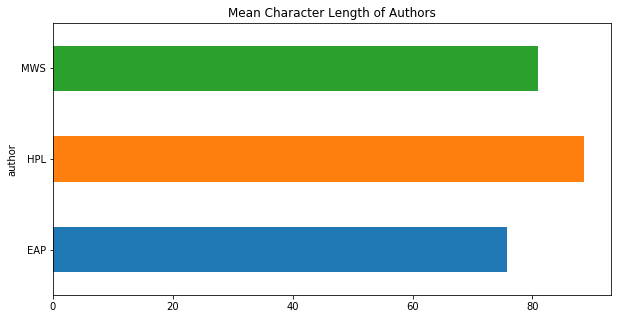

In [50]:
def charlen (text):
    sum=0
    for word in text:
        sum = sum+len(word)
    return sum
df['charlength'] = df['text'].apply(lambda x: charlen(x))
df.groupby(['author'])['charlength'].mean().plot(kind='barh')
plt.title('Mean Character Length of Authors')

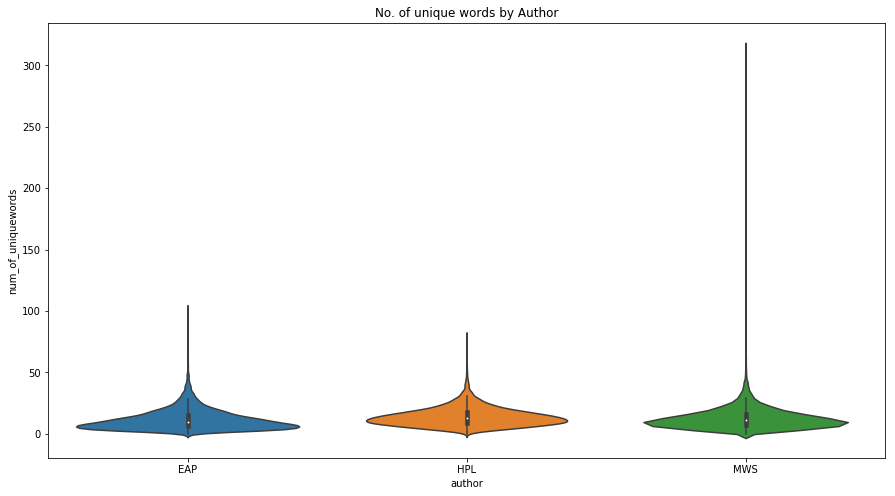

In [81]:
df['num_of_uniquewords'] = df['text'].apply(lambda x: len(set(str(x).split())))
plt.rcParams['figure.figsize'] = (15,8)
plt.title('No. of unique words by Author')
sns.violinplot(x='author', y='num_of_uniquewords', data = df)

*While the mean and interquartile ranges are not much different, MWS uses quite a few unique words which appear very rarely in his text*

Text(0.5, 1.0, 'Character Length v/s Author')

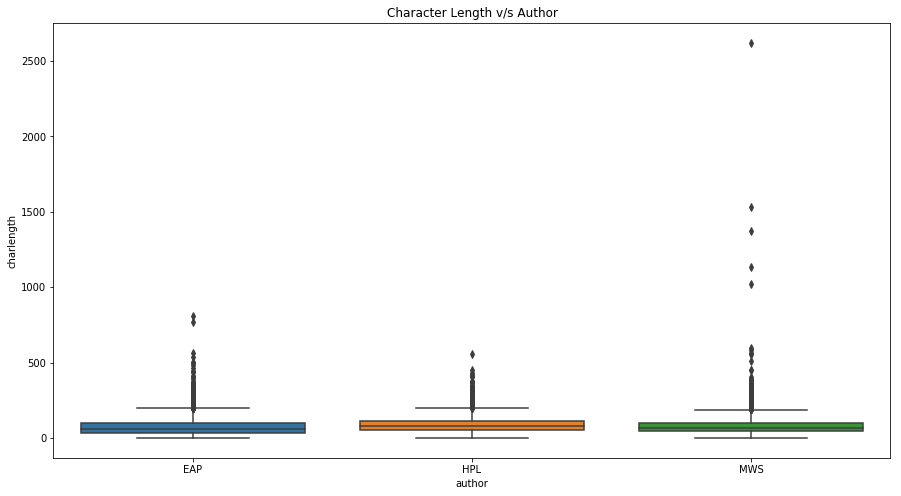

In [80]:
plt.rcParams['figure.figsize'] = (15,8)
sns.boxplot(df.author, df.charlength)
plt.title('Character Length v/s Author')

*Few of the text by MWS are considerably long, although less in number*

Text(0.5, 1.0, 'EAP WordCloud')

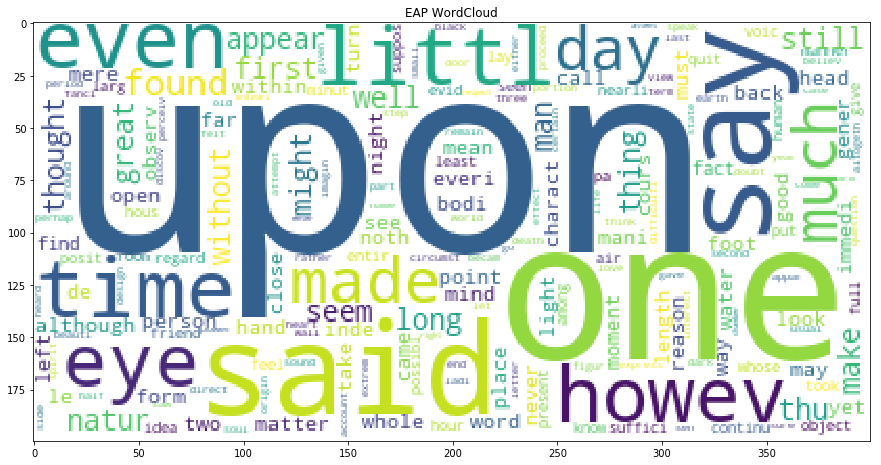

In [82]:
from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = [15,8]
authors = ['MWS', 'HPL', 'EAP']
eap = df.groupby(['author'], as_index=False)['text'].get_group('EAP').str.cat()
mws = df.groupby(['author'], as_index=False)['text'].get_group('MWS').str.cat()
hpl = df.groupby(['author'], as_index=False)['text'].get_group('HPL').str.cat()
wc = WordCloud(background_color="white").generate(eap)
plt.imshow(wc)
plt.title('EAP WordCloud')

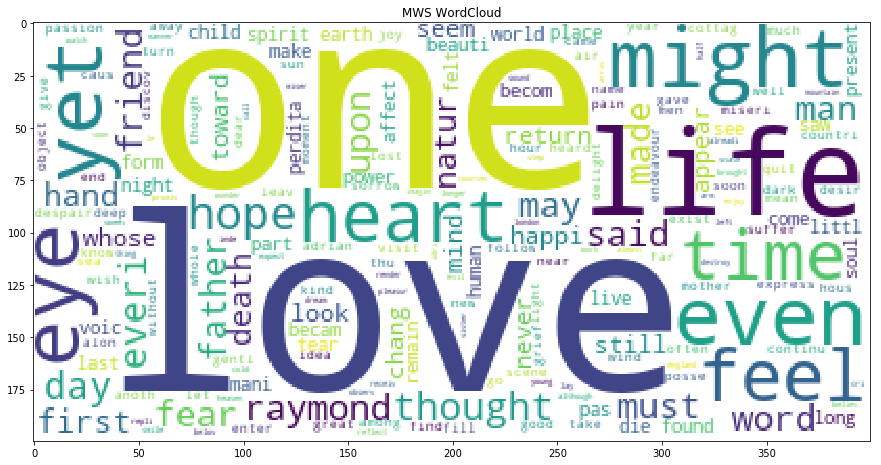

In [83]:
plt.rcParams['figure.figsize'] = [15,8]
wc2 = WordCloud(background_color="white").generate(mws)
plt.imshow(wc2)
plt.title('MWS WordCloud')
plt.show()

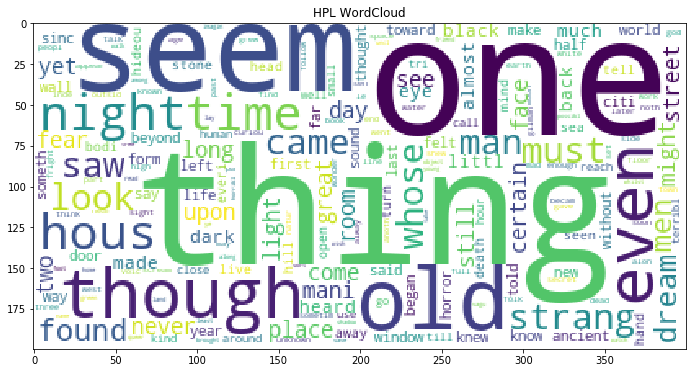

In [54]:
wc3 = WordCloud(background_color="white").generate(hpl)
plt.imshow(wc3)
plt.title('HPL WordCloud')
plt.show()

***Sentiment Analysis and comparison***

In [55]:
from textblob import TextBlob
df['Polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df.head()

,text,author,id_new,charlength,Polarity,Subjectivity
0,process howev afford mean ascertain dimens dun...,EAP,26305,138,-0.3125,0.6875
1,never occur fumbl might mere mistak,HPL,17569,35,-0.5000,0.5000
2,left hand gold snuff box caper hill cut manner...,EAP,11008,118,0.5000,0.5000
3,love spring look windsor terrac sixteen fertil...,MWS,27763,137,0.4000,0.5000
4,find noth el even gold superintend abandon att...,HPL,12958,101,0.0000,0.0000


In [56]:
df.groupby(['author'], as_index=False)['Polarity'].mean()

,author,Polarity
0,EAP,0.039394
1,HPL,0.021125
2,MWS,0.038700


In [57]:
df.groupby(['author'], as_index=False)['Subjectivity'].mean()

,author,Subjectivity
0,EAP,0.271168
1,HPL,0.323907
2,MWS,0.298750


***This is interesting! Hp Lovecraft's texts tend to be longer, bit more negative and more based on people's opinion (than factual) as compared to the text of Edgar Allan Poe and Mary Shelley***

**How similar are the text of different authors?**

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

In [59]:
print(cosine_sim(eap, mws), cosine_sim(eap, hpl), cosine_sim(hpl, mws))

0.7382856077047817 0.7370022318661033 0.7260691790819572


***As expected, EAP and MWS's text match more, and HPL's text is, in a way, an outlier. However, this also implies that it will be easier for our models to classify HPL's text.***

***Let us see how the polarity changes through the course of the text of different authors***

Text(0.5, 1.0, 'Variation of Sentiment of EAPs text')

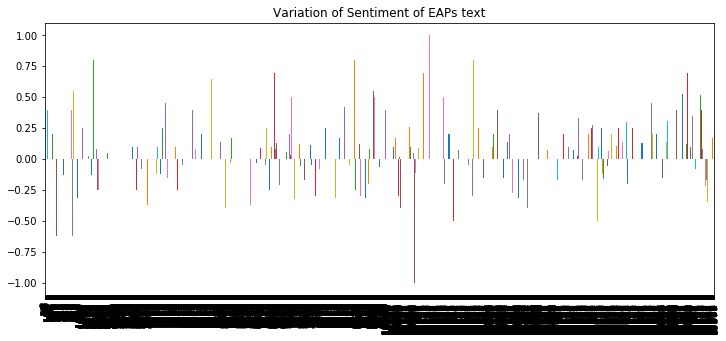

In [60]:
plt.rcParams['figure.figsize']=(12,5)
df_eap_pol = df.loc[df['author'] == 'EAP']
df_eap_pol.Polarity.plot(kind = 'bar')
plt.title('Variation of Sentiment of EAPs text')

Text(0.5, 1.0, 'Variation of Sentiment of HPLs text')

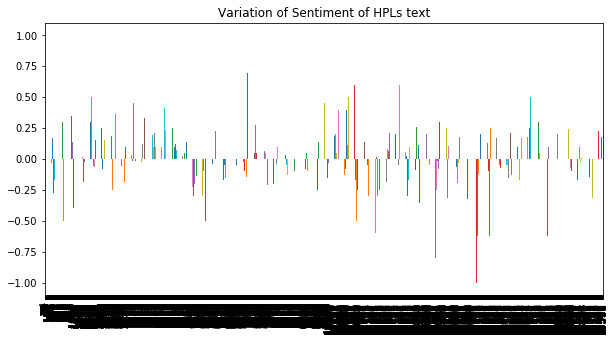

In [61]:
plt.rcParams['figure.figsize']=(10,5)
df_hpl_pol = df.loc[df['author'] == 'HPL']
df_hpl_pol.Polarity.plot(kind = 'bar')
plt.title('Variation of Sentiment of HPLs text')

Text(0.5, 1.0, 'Variation of Sentiment of MWSs text')

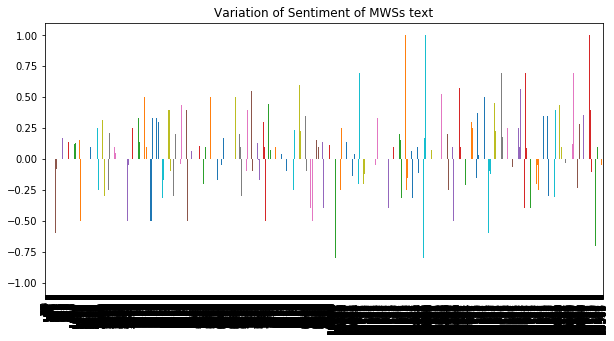

In [62]:
plt.rcParams['figure.figsize']=(10,5)
df_mws_pol = df.loc[df['author'] == 'MWS']
df_mws_pol.Polarity.plot(kind = 'bar')
plt.title('Variation of Sentiment of MWSs text')

*The sentiments expressed in MWS's text are a bit more intense during the second half and MWS's text usually leave the reader on a bit negative note at the end(haha!)*

***Latent Dirichlet Allocation to understand the text content of different authors***

In [63]:
import os.path
import gensim
from gensim import corpora
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from gensim.models.coherencemodel import CoherenceModel

In [64]:
eap_lda = eap.split()
hpl_lda = hpl.split()
mws_lda = mws.split()
dictionary_eap = Dictionary([eap_lda])
dictionary_hpl = Dictionary([hpl_lda])
dictionary_mws = Dictionary([mws_lda])
eap_term_matrix = [dictionary_eap.doc2bow(eap_lda)]
hpl_term_matrix = [dictionary_hpl.doc2bow(hpl_lda)]
mws_term_matrix = [dictionary_mws.doc2bow(mws_lda)]
Lda = gensim.models.ldamodel.LdaModel
ldamodel_eap = Lda(eap_term_matrix, num_topics=10, id2word = dictionary_eap, passes=100)
ldamodel_hpl = Lda(hpl_term_matrix, num_topics=10, id2word = dictionary_hpl, passes=100)
ldamodel_mws = Lda(mws_term_matrix, num_topics=10, id2word = dictionary_mws, passes=100)
print('EAP:', ldamodel_eap.print_topics(num_topics=10, num_words=10))
print('\n', 'HPL:', ldamodel_hpl.print_topics(num_topics=10, num_words=10))
print('\n', 'MWS:', ldamodel_mws.print_topics(num_topics=10, num_words=10))

EAP: [(0, '0.000*"upon" + 0.000*"one" + 0.000*"could" + 0.000*"said" + 0.000*"would" + 0.000*"made" + 0.000*"say" + 0.000*"even" + 0.000*"found" + 0.000*"day"'), (1, '0.000*"upon" + 0.000*"one" + 0.000*"could" + 0.000*"said" + 0.000*"say" + 0.000*"would" + 0.000*"littl" + 0.000*"time" + 0.000*"u" + 0.000*"eye"'), (2, '0.000*"upon" + 0.000*"one" + 0.000*"would" + 0.000*"could" + 0.000*"made" + 0.000*"said" + 0.000*"u" + 0.000*"much" + 0.000*"howev" + 0.000*"well"'), (3, '0.000*"upon" + 0.000*"one" + 0.000*"time" + 0.000*"could" + 0.000*"would" + 0.000*"said" + 0.000*"say" + 0.000*"littl" + 0.000*"two" + 0.000*"even"'), (4, '0.000*"upon" + 0.000*"one" + 0.000*"would" + 0.000*"could" + 0.000*"say" + 0.000*"littl" + 0.000*"even" + 0.000*"day" + 0.000*"howev" + 0.000*"made"'), (5, '0.000*"upon" + 0.000*"could" + 0.000*"one" + 0.000*"would" + 0.000*"even" + 0.000*"said" + 0.000*"time" + 0.000*"howev" + 0.000*"eye" + 0.000*"littl"'), (6, '0.011*"upon" + 0.006*"one" + 0.004*"could" + 0.004*"wo

In [65]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['author'], test_size = 0.25)
X_train.shape, X_test.shape

((14684,), (4895,))

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer(stop_words = 'english')
training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)
predictions = naive_bayes.predict(testing_data)

In [68]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, predictions)
print('Accuracy NB:', acc)

Accuracy NB: 0.8218590398365679


In [69]:
from sklearn import svm
SV = svm.SVC()
SV.fit(training_data, y_train)
predictions_sv = SV.predict(testing_data)

C:\Users\Harsh\.LSC\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [70]:
from sklearn.metrics import accuracy_score
acc1 = accuracy_score(y_test, predictions_sv)
print('Accuracy SVC:', acc1)

Accuracy SVC: 0.4


In [71]:
import xgboost as xgb
xgb_class=xgb.XGBClassifier()
xgb_class.fit(training_data, y_train)
predictions_xgb = xgb_class.predict(testing_data)
acc2 = accuracy_score(y_test, predictions_xgb)
print('Accuracy XGB:', acc2)

Accuracy XGB: 0.5961184882533197
